# SIT378 – Redback Operations: Data Analytics Team
# Modelling Athlete Fatigue, Injury Risk & Recovery with Environmental Factors

> Purpose: a clean, reproducible notebook that loads and cleans activity data, builds simple baselines, integrates synthetic environment features, prepares Power BI exports, and provides visual/evidence outputs for the team.

> Author: Benjamin Cole - s222237823


### Data Variability & How to Adapt (Read Me First)

This notebook is designed to **fail safely** when expected columns/files are missing. Many steps **depend on your data**.  
If something doesn't run, it's usually because a **file path or column name** differs from what's assumed here.

**Common points to adjust:**
- **File paths**: Change `Data/ImprovedData.xlsx`, `Data/Cycling.csv`, `Data/Football.csv` if your tree is different.
- **Sheet names**: If your Excel file has multiple sheets, select the correct one explicitly.
- **Column names**: Update the schema mapper if your columns differ (e.g., `Average Heart Rate` vs `avg_hr`).  
- **Targets**: Real targets like `fatigue_score`, `injury_flag`, `recovery_hours` may not exist; we **simulate** them for baselines.
- **Environment data**: If you have real weather, replace synthetic `temp_c`, `humidity_pct`, `wind_kph` with your joined dataset.

**Troubleshooting pattern**: 
1) Read the comment at the top of the cell (what it needs).  
2) If a KeyError/FileNotFound occurs, tweak the **path** or the **column map**.  
3) Re-run the cell; proceed only if the printed checks look right.



### Quick Helper — Verify Paths & Columns

Use the helper below to verify that paths exist and to preview column names.  
If a file is missing or a key column is absent, adapt the **path** or **schema map** accordingly.


In [1]:

from pathlib import Path
import pandas as pd

# === Update these if your tree differs ===
RUN_PATH = Path("Data/ImprovedData.xlsx")
CYC_PATH = Path("Data/Cycling.csv")
FB_PATH  = Path("Data/Football.csv")

print("Paths exist?",
      "\n  RUN:", RUN_PATH.exists(),
      "\n  CYC:", CYC_PATH.exists(),
      "\n  FB :", FB_PATH.exists())

def preview_cols(path):
    try:
        if path.suffix.lower()==".csv":
            df = pd.read_csv(path, nrows=3)
        else:
            try:
                x = pd.ExcelFile(path)
                df = x.parse(x.sheet_names[0]).head(3)
            except Exception:
                df = pd.read_excel(path, nrows=3)
        print(f"\nFirst 3 rows and columns for: {path}")
        print(df.head(3))
        print("Columns:", list(df.columns))
    except Exception as e:
        print(f"Could not preview {path}:", e)

for p in [RUN_PATH, CYC_PATH, FB_PATH]:
    preview_cols(p)


Paths exist? 
  RUN: True 
  CYC: True 
  FB : True

First 3 rows and columns for: Data\ImprovedData.xlsx
    UserID      Name Location  Total_Distance  Very_Active_Distance  \
0  7423388  Danielle      QLD            8.02                  2.03   
1  7550634     Angel      NSW            5.82                  2.28   
2  5304572    Joshua      NSW            0.11                  0.00   

   Moderately_Active_Distance  Light_Active_Distance  \
0                        0.48                   5.52   
1                        0.90                   2.64   
2                        0.00                   0.11   

   Sedentary_Active_Distance  Very_Active_Minutes  Fairly_Active_Minutes  \
0                        0.0                   26                     10   
1                        0.0                   30                     16   
2                        0.0                    0                      0   

   Lightly_Active_Minutes  Sedentary_Minutes  Steps  Calories_Burned  
0       

In [2]:
from pathlib import Path
print("DATA_DIR exists:", Path("Data").exists())
print("ImprovedData.xlsx exists:", Path("Data/ImprovedData.xlsx").exists())
print("Cycling.csv exists:", Path("Data/Cycling.csv").exists())
print("Football.csv exists:", Path("Data/Football.csv").exists())
print("Output CSV dir:", Path("Data/output/csv").resolve())
print("Output FIG dir:", Path("Data/output/figures").resolve())

DATA_DIR exists: True
ImprovedData.xlsx exists: True
Cycling.csv exists: True
Football.csv exists: True
Output CSV dir: C:\Users\bmcol\University\SIT378\Data\output\csv
Output FIG dir: C:\Users\bmcol\University\SIT378\Data\output\figures


### Imported cells — Early submission

In [3]:
# Step 1: Importing Required Libraries
# I am using Pandas for data handling, NumPy for numerical operations,
# Matplotlib & Seaborn for visualisation, and Scikit-learn for modelling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pathlib import Path
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




In [4]:
# Step 1: Correct path to the dataset
IMPROVED_XLSX = Path("Data") / "ImprovedData.xlsx"

# Step 2: Load the Activity Dataset
df = pd.read_excel(IMPROVED_XLSX)

# Step 3: Inspect first 5 rows
df.head()


,UserID,Name,Location,Total_Distance,Very_Active_Distance,Moderately_Active_Distance,Light_Active_Distance,Sedentary_Active_Distance,Very_Active_Minutes,Fairly_Active_Minutes,Lightly_Active_Minutes,Sedentary_Minutes,Steps,Calories_Burned
0,7423388,Danielle,QLD,8.02,2.03,0.48,5.52,0.0,26,10,349,587,10449,2536
1,7550634,Angel,NSW,5.82,2.28,0.90,2.64,0.0,30,16,135,1259,8001,2902
2,5304572,Joshua,NSW,0.11,0.00,0.00,0.11,0.0,0,0,12,1303,152,2100
3,3234489,Jeffrey,NSW,7.21,0.00,0.34,6.87,0.0,0,7,352,1077,9543,2450
4,8204212,Jill,QLD,7.86,0.34,0.73,6.79,0.0,6,19,258,1020,10218,3013


In [5]:
# Step 3: Dataset Info
# This will show me the column names, their types, and whether there are any missing values.
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   UserID                      863 non-null    int64  
 1   Name                        863 non-null    object 
 2   Location                    863 non-null    object 
 3   Total_Distance              863 non-null    float64
 4   Very_Active_Distance        863 non-null    float64
 5   Moderately_Active_Distance  863 non-null    float64
 6   Light_Active_Distance       863 non-null    float64
 7   Sedentary_Active_Distance   863 non-null    float64
 8   Very_Active_Minutes         863 non-null    int64  
 9   Fairly_Active_Minutes       863 non-null    int64  
 10  Lightly_Active_Minutes      863 non-null    int64  
 11  Sedentary_Minutes           863 non-null    int64  
 12  Steps                       863 non-null    int64  
 13  Calories_Burned             863 non

In [6]:
# Step 4: Check for Missing Values
print("Missing Values Before Cleaning:")
print(df.isnull().sum())  


Missing Values Before Cleaning:
UserID                        0
Name                          0
Location                      0
Total_Distance                0
Very_Active_Distance          0
Moderately_Active_Distance    0
Light_Active_Distance         0
Sedentary_Active_Distance     0
Very_Active_Minutes           0
Fairly_Active_Minutes         0
Lightly_Active_Minutes        0
Sedentary_Minutes             0
Steps                         0
Calories_Burned               0
dtype: int64


In [7]:
# Step 5: Clean Data 
# For early analysis, I am filling missing numeric values with the column mean.
# This keeps the dataset usable for the modelling without having removing rows.
df = df.fillna(df.mean(numeric_only=True))

print("\nMissing Values After Cleaning:")
print(df.isnull().sum())  


Missing Values After Cleaning:
UserID                        0
Name                          0
Location                      0
Total_Distance                0
Very_Active_Distance          0
Moderately_Active_Distance    0
Light_Active_Distance         0
Sedentary_Active_Distance     0
Very_Active_Minutes           0
Fairly_Active_Minutes         0
Lightly_Active_Minutes        0
Sedentary_Minutes             0
Steps                         0
Calories_Burned               0
dtype: int64


In [8]:
# Step 6: Simulate Environmental Data
# Since the current dataset does not have Temperature, Humidity, or Wind Speed,
# I am generating placeholder values. This lets me design the correlation analysis now so it will work the same way when real data is available.
np.random.seed(42)  # for reproducibility
df["Temperature"] = np.random.normal(20, 5, len(df))  # mean 20°C
df["Humidity"] = np.random.randint(40, 90, len(df))   # 40-90%
df["WindSpeed"] = np.random.uniform(0, 30, len(df))   # 0-30 km/h

df.head()

,UserID,Name,Location,Total_Distance,Very_Active_Distance,Moderately_Active_Distance,Light_Active_Distance,Sedentary_Active_Distance,Very_Active_Minutes,Fairly_Active_Minutes,Lightly_Active_Minutes,Sedentary_Minutes,Steps,Calories_Burned,Temperature,Humidity,WindSpeed
0,7423388,Danielle,QLD,8.02,2.03,0.48,5.52,0.0,26,10,349,587,10449,2536,22.483571,73,4.779121
1,7550634,Angel,NSW,5.82,2.28,0.90,2.64,0.0,30,16,135,1259,8001,2902,19.308678,50,1.893271
2,5304572,Joshua,NSW,0.11,0.00,0.00,0.11,0.0,0,0,12,1303,152,2100,23.238443,80,3.529471
3,3234489,Jeffrey,NSW,7.21,0.00,0.34,6.87,0.0,0,7,352,1077,9543,2450,27.615149,42,6.820719
4,8204212,Jill,QLD,7.86,0.34,0.73,6.79,0.0,6,19,258,1020,10218,3013,18.829233,67,10.250235


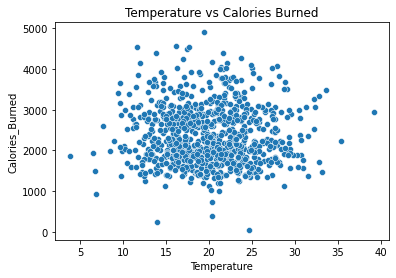

In [9]:
# Step 7: Scatter Plot - Temperature vs Calories Burned
# Plotting Temperature vs Calories Burned to see if there is any relationship
sns.scatterplot(data=df, x="Temperature", y="Calories_Burned")
plt.title("Temperature vs Calories Burned")
plt.show()  # Screenshot for Evidence 4

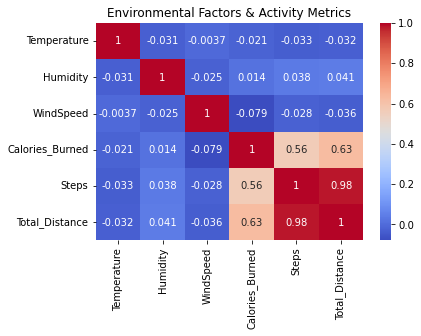

In [10]:
# Step 8: Correlation Heatmap
# This shows how environmental and activity metrics relate to each other.
# This will be repeated with real data for more accurate insights.
env_cols = ["Temperature", "Humidity", "WindSpeed", "Calories_Burned", "Steps", "Total_Distance"]
corr = df[env_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Environmental Factors & Activity Metrics")
plt.show()  # Screenshot for Evidence 4

In [11]:
# Step 9: Simulate Fatigue Level for Baseline Model
# Fatigue is one of the key performance metrics I will model in this project.
# For now, I am creating a fake random target variable to allow model pipeline testing.
df["FatigueLevel"] = np.random.uniform(0, 10, len(df))

In [12]:
# Step 10: Prepare Model Data
# Using activity metrics as features; target is FatigueLevel.
X = df[["Total_Distance", "Very_Active_Minutes", "Steps"]]
y = df["FatigueLevel"]


In [13]:
# Step 11: Train-Test Split
# This is to ensures the model is tested on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Step 12: Train Baseline Model
# Using this as a baseline performance.
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [15]:
# Step 13: Evaluate Model
# Using Mean Squared Error (MSE) as the evaluation metric.
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Baseline Fatigue Prediction MSE:", mse) 

Baseline Fatigue Prediction MSE: 8.22249300032724


### Imported cells — Minimal Visualisations

# SIT378 – Minimal Visualisations (Flat) — Inline + Saved

Plots **display inline** and are **saved** to `Data/output/figures/`.

In [16]:
# [0] Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Paths (flat structure)
ROOT = Path.cwd()
DATA_DIR = ROOT / "Data"
OUT_DIR = DATA_DIR / "output"
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR.resolve())
print("OUT_DIR :", OUT_DIR.resolve())
print("FIG_DIR :", FIG_DIR.resolve())

DATA_DIR: C:\Users\bmcol\University\SIT378\Data
OUT_DIR : C:\Users\bmcol\University\SIT378\Data\output
FIG_DIR : C:\Users\bmcol\University\SIT378\Data\output\figures


In [17]:
# [1] Load the three spreadsheets from Data/
def _read_any(p: Path) -> pd.DataFrame:
    try:
        if p.suffix.lower()==".csv":
            return pd.read_csv(p)
        else:
            return pd.read_excel(p)
    except Exception as e:
        print(f"[WARN] Failed to read {p}: {e}")
        return pd.DataFrame()

cycling_path  = (DATA_DIR / "Cycling.csv")
running_path  = (DATA_DIR / "ImprovedData.xlsx")
football_path = (DATA_DIR / "Football.csv")

# Fallbacks for this environment preview; ignore on your machine if not needed
if not cycling_path.exists():  cycling_path  = Path("/mnt/data/Cycling.csv")
if not running_path.exists():  running_path  = Path("/mnt/data/ImprovedData.xlsx")
if not football_path.exists(): football_path = Path("/mnt/data/Football.csv")

dfs = {
    "cycling":  _read_any(cycling_path),
    "running":  _read_any(running_path),
    "football": _read_any(football_path),
}
sources = {
    "cycling":  str(cycling_path),
    "running":  str(running_path),
    "football": str(football_path),
}

for k,df in dfs.items():
    print(f"{k:8s} -> shape={df.shape} | source={sources[k]}")
    print(f"{k:8s} cols:", list(df.columns))

cycling  -> shape=(181, 42) | source=C:\Users\bmcol\University\SIT378\Data\Cycling.csv
cycling  cols: ['Activity Date', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Athlete Weight', 'Bike Weight', 'Moving Time', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Total Work', 'Perceived Exertion', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Grade Adjusted Distance', 'Average Elapsed Speed', '60 Day Maximum Power 5s', '60 Day Maximum Power 10s', '60 Day Maximum Power 30s', '60 Day Maximum Power 1.0min', '60 Day Maximum Power 5.0min', '60 Day Maximum Power 10.0min', '60 Day Maximum Power 20.0min', '60 Day Maximum Power 30.0min', '60 Day Maximum Power 1.0 hr', '60 Day Maximum Power 1.5 hr', '60 Day Maximum Power 2.0 hr', 'FTP']


In [18]:
# [2] Save+Show helper
def save_and_show(name):
    # Save current figure and also show inline
    p = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(p, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print("Saved:", p)

Running columns: ['UserID', 'Name', 'Location', 'Total_Distance', 'Very_Active_Distance', 'Moderately_Active_Distance', 'Light_Active_Distance', 'Sedentary_Active_Distance', 'Very_Active_Minutes', 'Fairly_Active_Minutes', 'Lightly_Active_Minutes', 'Sedentary_Minutes', 'Steps', 'Calories_Burned']


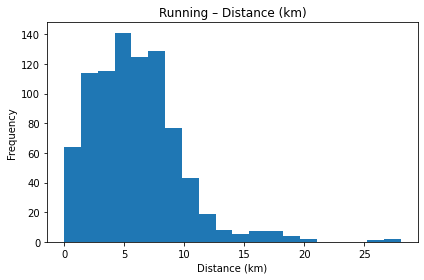

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\run_hist_distance.png


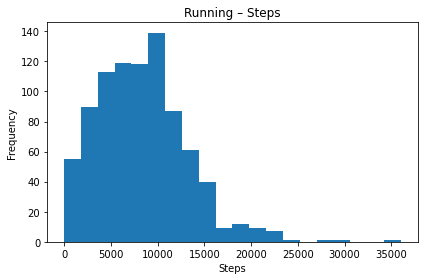

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\run_hist_steps.png


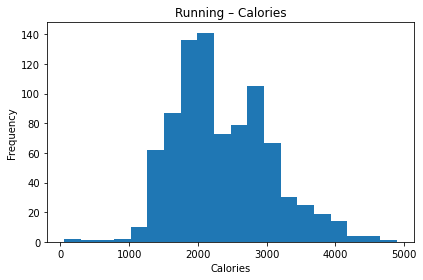

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\run_hist_calories.png


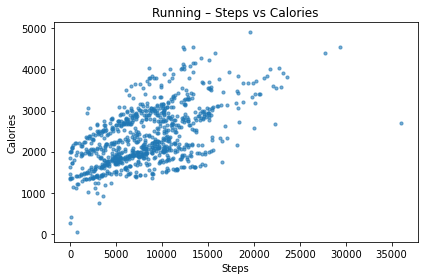

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\run_steps_vs_calories.png


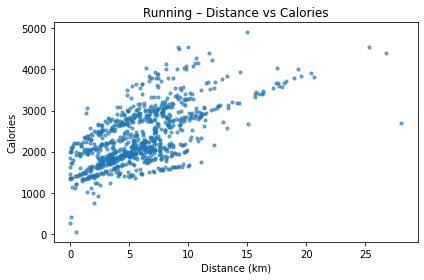

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\run_distance_vs_calories.png


In [19]:
# [3] Running visuals (ImprovedData.xlsx)
run = dfs["running"].copy()
print("Running columns:", list(run.columns))

# Light column mapping
colmap = {
    'Total_Distance': 'distance_km',
    'Distance_km': 'distance_km',
    'Steps': 'steps',
    'Calories_Burned': 'calories',
    'Calories': 'calories',
}
for a,b in colmap.items():
    if a in run.columns: run.rename(columns={a:b}, inplace=True)

if not run.empty:
    # Histograms
    if 'distance_km' in run and run['distance_km'].notna().sum() >= 5:
        run['distance_km'].plot(kind='hist', bins=20, title='Running – Distance (km)'); plt.xlabel('Distance (km)')
        save_and_show('run_hist_distance.png')
    if 'steps' in run and run['steps'].notna().sum() >= 5:
        run['steps'].plot(kind='hist', bins=20, title='Running – Steps'); plt.xlabel('Steps')
        save_and_show('run_hist_steps.png')
    if 'calories' in run and run['calories'].notna().sum() >= 5:
        run['calories'].plot(kind='hist', bins=20, title='Running – Calories'); plt.xlabel('Calories')
        save_and_show('run_hist_calories.png')
    # Scatters
    if {'steps','calories'}.issubset(run.columns):
        d = run[['steps','calories']].dropna()
        if len(d) >= 10:
            plt.figure(); plt.scatter(d['steps'], d['calories'], s=10, alpha=0.6)
            plt.xlabel('Steps'); plt.ylabel('Calories'); plt.title('Running – Steps vs Calories')
            save_and_show('run_steps_vs_calories.png')
    if {'distance_km','calories'}.issubset(run.columns):
        d = run[['distance_km','calories']].dropna()
        if len(d) >= 10:
            plt.figure(); plt.scatter(d['distance_km'], d['calories'], s=10, alpha=0.6)
            plt.xlabel('Distance (km)'); plt.ylabel('Calories'); plt.title('Running – Distance vs Calories')
            save_and_show('run_distance_vs_calories.png')
else:
    print("[3] Running: no data or columns not present — skipped")

Cycling columns: ['Activity Date', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Athlete Weight', 'Bike Weight', 'Moving Time', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Total Work', 'Perceived Exertion', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Grade Adjusted Distance', 'Average Elapsed Speed', '60 Day Maximum Power 5s', '60 Day Maximum Power 10s', '60 Day Maximum Power 30s', '60 Day Maximum Power 1.0min', '60 Day Maximum Power 5.0min', '60 Day Maximum Power 10.0min', '60 Day Maximum Power 20.0min', '60 Day Maximum Power 30.0min', '60 Day Maximum Power 1.0 hr', '60 Day Maximum Power 1.5 hr', '60 Day Maximum Power 2.0 hr', 'FTP']


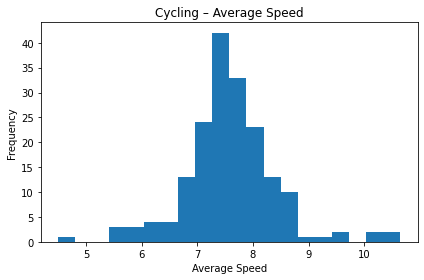

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\cyc_hist_avg_speed.png


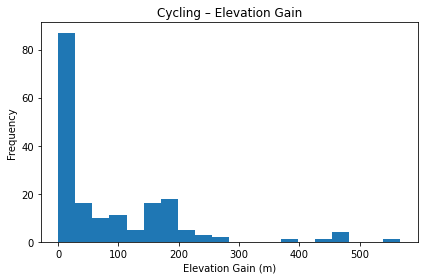

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\cyc_hist_elev_gain.png


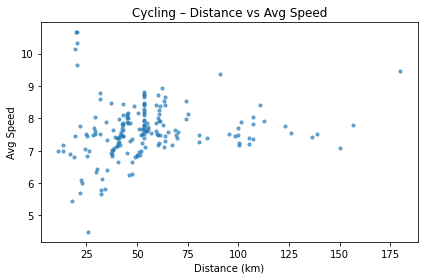

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\cyc_distance_vs_avg_speed.png


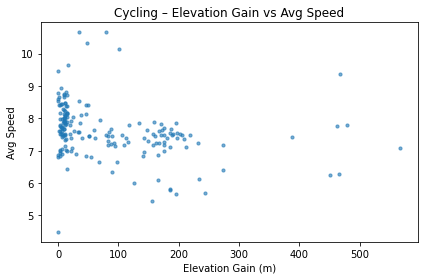

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\cyc_elev_vs_avg_speed.png


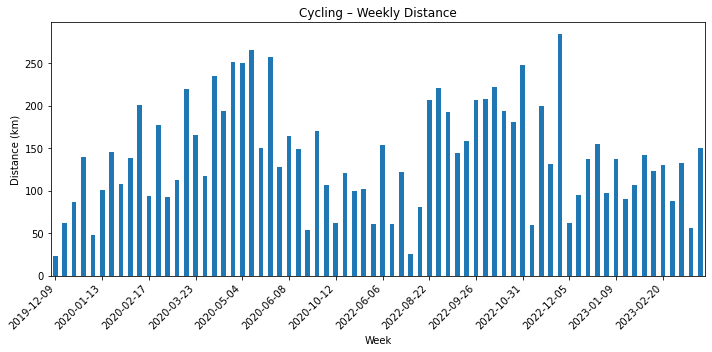

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\cyc_weekly_distance.png


In [20]:
# [4] Cycling visuals (Cycling.csv)
cyc = dfs["cycling"].copy()
print("Cycling columns:", list(cyc.columns))

# Rename if present
cmap = {
    'Activity Date': 'date',
    'Date': 'date',
    'Distance': 'distance_km',
    'Average Speed': 'avg_speed',
    'Avg Speed': 'avg_speed',
    'Elevation Gain': 'elev_gain',
    'Elev Gain': 'elev_gain',
}
for a, b in cmap.items():
    if a in cyc.columns:
        cyc.rename(columns={a: b}, inplace=True)

if not cyc.empty:
    # --- Histograms ---
    if 'avg_speed' in cyc and cyc['avg_speed'].notna().sum() >= 5:
        cyc['avg_speed'].plot(kind='hist', bins=20, title='Cycling – Average Speed')
        plt.xlabel('Average Speed')
        save_and_show('cyc_hist_avg_speed.png')

    if 'elev_gain' in cyc and cyc['elev_gain'].notna().sum() >= 5:
        cyc['elev_gain'].plot(kind='hist', bins=20, title='Cycling – Elevation Gain')
        plt.xlabel('Elevation Gain (m)')
        save_and_show('cyc_hist_elev_gain.png')

    # --- Scatters ---
    if {'distance_km', 'avg_speed'}.issubset(cyc.columns):
        d = cyc[['distance_km', 'avg_speed']].dropna()
        if len(d) >= 10:
            plt.figure()
            plt.scatter(d['distance_km'], d['avg_speed'], s=10, alpha=0.6)
            plt.xlabel('Distance (km)'); plt.ylabel('Avg Speed'); plt.title('Cycling – Distance vs Avg Speed')
            save_and_show('cyc_distance_vs_avg_speed.png')

    if {'elev_gain', 'avg_speed'}.issubset(cyc.columns):
        d = cyc[['elev_gain', 'avg_speed']].dropna()
        if len(d) >= 10:
            plt.figure()
            plt.scatter(d['elev_gain'], d['avg_speed'], s=10, alpha=0.6)
            plt.xlabel('Elevation Gain (m)'); plt.ylabel('Avg Speed'); plt.title('Cycling – Elevation Gain vs Avg Speed')
            save_and_show('cyc_elev_vs_avg_speed.png')

    # --- Weekly distance (improved ticks) ---
    if {'date', 'distance_km'}.issubset(cyc.columns):
        try:
            cyc['date'] = pd.to_datetime(cyc['date'], errors='coerce')
            d = cyc.dropna(subset=['date', 'distance_km']).copy()
            if len(d) >= 5:
                d['week'] = d['date'].dt.to_period('W').dt.start_time
                weekly = d.groupby('week', as_index=True)['distance_km'].sum().sort_index()

                if len(weekly) >= 2:
                    fig, ax = plt.subplots(figsize=(10, 5))
                    weekly.plot(kind='bar', ax=ax, title='Cycling – Weekly Distance')
                    ax.set_ylabel('Distance (km)')
                    ax.set_xlabel('Week')

                    # show ~12 evenly spaced labels (adjusts automatically for data length)
                    step = max(1, len(weekly) // 12)
                    ticks = list(range(0, len(weekly), step))
                    ax.set_xticks(ticks)
                    ax.set_xticklabels(
                        [weekly.index[i].strftime('%Y-%m-%d') for i in ticks],
                        rotation=45, ha='right'
                    )

                    save_and_show('cyc_weekly_distance.png')
        except Exception as e:
            print("[INFO] Skipped weekly distance (date parse failed):", e)
else:
    print("[4] Cycling: no data — skipped")


Football columns: ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'H_Ranking_Prior_Season', 'A_Ranking_Prior_Season', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']


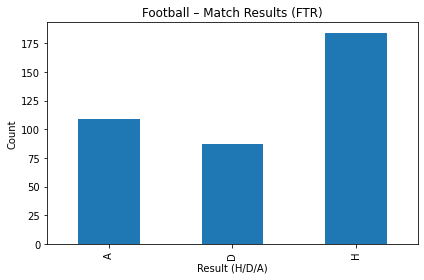

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\ftb_results_counts.png


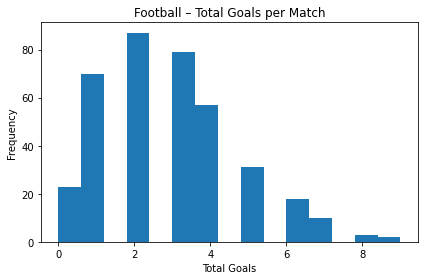

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\ftb_total_goals_hist.png


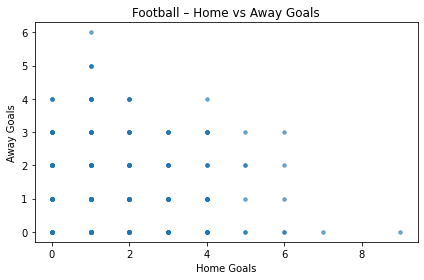

Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\ftb_home_vs_away_goals.png


In [21]:
# [5] Football visuals (Football.csv)
ftb = dfs["football"].copy()
print("Football columns:", list(ftb.columns))

if not ftb.empty and {'FTR','FTHG','FTAG'}.issubset(ftb.columns):
    ftb['FTR'].value_counts().sort_index().plot(kind='bar', title='Football – Match Results (FTR)')
    plt.xlabel('Result (H/D/A)'); plt.ylabel('Count')
    save_and_show('ftb_results_counts.png')
    
    (ftb['FTHG'] + ftb['FTAG']).plot(kind='hist', bins=15, title='Football – Total Goals per Match')
    plt.xlabel('Total Goals')
    save_and_show('ftb_total_goals_hist.png')
    
    d = ftb[['FTHG','FTAG']].dropna()
    if len(d) >= 10:
        plt.figure(); plt.scatter(d['FTHG'], d['FTAG'], s=12, alpha=0.6)
        plt.xlabel('Home Goals'); plt.ylabel('Away Goals'); plt.title('Football – Home vs Away Goals')
        save_and_show('ftb_home_vs_away_goals.png')
else:
    print("[5] Football: missing FTR/FTHG/FTAG or no data — skipped")

In [22]:
# [6] Figure checklist
expected = [
    'run_hist_distance.png','run_hist_steps.png','run_hist_calories.png',
    'run_steps_vs_calories.png','run_distance_vs_calories.png',
    'cyc_hist_avg_speed.png','cyc_hist_elev_gain.png','cyc_distance_vs_avg_speed.png',
    'cyc_elev_vs_avg_speed.png','cyc_weekly_distance.png',
    'ftb_results_counts.png','ftb_total_goals_hist.png','ftb_home_vs_away_goals.png',
]
rows = []
for name in expected:
    p = FIG_DIR / name
    rows.append({"figure": name, "exists": "✅" if p.exists() else "❌", "path": str(p if p.exists() else FIG_DIR)})
import pandas as pd
pd.DataFrame(rows)

,figure,exists,path
0,run_hist_distance.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
1,run_hist_steps.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
2,run_hist_calories.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
3,run_steps_vs_calories.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
4,run_distance_vs_calories.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
5,cyc_hist_avg_speed.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
6,cyc_hist_elev_gain.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
7,cyc_distance_vs_avg_speed.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
8,cyc_elev_vs_avg_speed.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...
9,cyc_weekly_distance.png,✅,C:\Users\bmcol\University\SIT378\Data\output\f...


### Dataset familiarisation & cleaning (no weekly headings)

Update the `IMPROVED_XLSX` path and run the inspection and basic cleaning blocks. Outputs go to `outputs/csv/`.


In [23]:

from pathlib import Path
import pandas as pd
import numpy as np

# --- Paths: UPDATE as needed ---
DATA_DIR = Path("Data")  # using your provided tree
IMPROVED_XLSX = DATA_DIR / "ImprovedData.xlsx"  # e.g., r"C:\...\ImprovedData.xlsx"
OUTPUTS_CSV = Path("Data/output/csv"); OUTPUTS_FIG = Path("Data/output/figures")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True); OUTPUTS_FIG.mkdir(parents=True, exist_ok=True)

print("Configured paths:")
print("  IMPROVED_XLSX:", IMPROVED_XLSX.resolve())
print("  OUTPUTS_CSV:", OUTPUTS_CSV.resolve())
print("  OUTPUTS_FIG:", OUTPUTS_FIG.resolve())


Configured paths:
  IMPROVED_XLSX: C:\Users\bmcol\University\SIT378\Data\ImprovedData.xlsx
  OUTPUTS_CSV: C:\Users\bmcol\University\SIT378\Data\output\csv
  OUTPUTS_FIG: C:\Users\bmcol\University\SIT378\Data\output\figures


In [24]:

# Load & inspect
try:
    xls = pd.ExcelFile(IMPROVED_XLSX)
    print("Sheets:", xls.sheet_names)
    # If multiple sheets, pick the first by default:
    df = xls.parse(xls.sheet_names[0])
    print(df.head(3))
    print(df.info())
    na_rate = df.isna().mean().sort_values(ascending=False)
    print("Missingness (top 20):\n", na_rate.head(20))
except Exception as e:
    print("Could not load ImprovedData.xlsx:", e)
    df = pd.DataFrame()


Sheets: ['Sheet1']
    UserID      Name Location  Total_Distance  Very_Active_Distance  \
0  7423388  Danielle      QLD            8.02                  2.03   
1  7550634     Angel      NSW            5.82                  2.28   
2  5304572    Joshua      NSW            0.11                  0.00   

   Moderately_Active_Distance  Light_Active_Distance  \
0                        0.48                   5.52   
1                        0.90                   2.64   
2                        0.00                   0.11   

   Sedentary_Active_Distance  Very_Active_Minutes  Fairly_Active_Minutes  \
0                        0.0                   26                     10   
1                        0.0                   30                     16   
2                        0.0                    0                      0   

   Lightly_Active_Minutes  Sedentary_Minutes  Steps  Calories_Burned  
0                     349                587  10449             2536  
1                     13

In [25]:

# Standardise columns: lowercase snake_case, parse timestamps, coerce numerics where obvious
def to_snake(s):
    return (s.strip()
              .replace(" ", "_")
              .replace("-", "_")
              .replace("/", "_")
              .lower())

def coerce_numeric(series):
    try:
        return pd.to_numeric(series, errors="coerce")
    except Exception:
        return series

if not df.empty:
    df.columns = [to_snake(c) for c in df.columns]
    # Try common timestamp columns
    for c in ["timestamp","date","activity_date","start_time","start_datetime"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    # Coerce numerics for common metrics
    for c in df.columns:
        if c not in ["timestamp","date","activity_date","start_time","start_datetime"]:
            if df[c].dtype == object:
                df[c] = coerce_numeric(df[c])
    print("After standardisation:\n", df.head(3))
else:
    print("df is empty; skip standardisation.")


After standardisation:
     userid  name  location  total_distance  very_active_distance  \
0  7423388   NaN       NaN            8.02                  2.03   
1  7550634   NaN       NaN            5.82                  2.28   
2  5304572   NaN       NaN            0.11                  0.00   

   moderately_active_distance  light_active_distance  \
0                        0.48                   5.52   
1                        0.90                   2.64   
2                        0.00                   0.11   

   sedentary_active_distance  very_active_minutes  fairly_active_minutes  \
0                        0.0                   26                     10   
1                        0.0                   30                     16   
2                        0.0                    0                      0   

   lightly_active_minutes  sedentary_minutes  steps  calories_burned  
0                     349                587  10449             2536  
1                     135      

In [26]:

# Basic cleaning: drop mostly empty columns, simple imputations for numerics
if not df.empty:
    # Drop columns with >95% missing
    keep_cols = [c for c in df.columns if df[c].isna().mean() < 0.95]
    df = df[keep_cols].copy()
    # Simple imputations
    num_cols = df.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].mean())
    # Export
    out_file = OUTPUTS_CSV / "activities_w1to3_clean.csv"
    df.to_csv(out_file, index=False)
    print("Saved:", out_file.resolve(), "shape:", df.shape)
else:
    print("df is empty; skip cleaning/export.")


Saved: C:\Users\bmcol\University\SIT378\Data\output\csv\activities_w1to3_clean.csv shape: (863, 12)


### Baselines and environment placeholders

Define target columns if present. Add lightweight baselines for fatigue (regression), injury risk (classification), and recovery time (regression). If environmental data is missing, generate synthetic placeholders with a fixed seed so results are reproducible.


In [27]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
import pandas as pd

# Targets: update if your columns differ
target_fatigue = "fatigue_score"      # e.g., 0-10 scale
target_injury  = "injury_flag"        # 0/1
target_recover = "recovery_hours"     # continuous

rng = np.random.default_rng(42)

if not df.empty:
    work = df.copy()
    # Synthetic env if missing
    for col in ["temp_c","humidity_pct","wind_kph"]:
        if col not in work.columns:
            work[col] = rng.normal(loc=20 if col=="temp_c" else (60 if col=="humidity_pct" else 10), scale=5, size=len(work))
    # Simple feature guess: all numerics except targets
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    for t in [target_fatigue, target_injury, target_recover]:
        if t not in work.columns:
            # create dummy targets for scaffolding
            if t == target_injury:
                work[t] = (rng.random(len(work)) > 0.7).astype(int)
            else:
                work[t] = np.clip(rng.normal(5, 2, len(work)), 0, None)

    # Fatigue baseline (LinearRegression)
    X = work[[c for c in num_cols if c not in [target_fatigue, target_injury, target_recover]]].fillna(0)
    y = work[target_fatigue]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lr = LinearRegression().fit(X_train, y_train)
    pred = lr.predict(X_test)
    print("Fatigue baseline — MAE:", mean_absolute_error(y_test, pred),
          "MSE:", mean_squared_error(y_test, pred),
          "R2:", r2_score(y_test, pred))

    # Injury baseline (LogisticRegression)
    y2 = work[target_injury].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.25, random_state=42, stratify=y2)
    logit = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    p = logit.predict_proba(X_test)[:,1]
    yhat = (p > 0.5).astype(int)
    try:
        auc = roc_auc_score(y_test, p)
    except Exception:
        auc = float("nan")
    print("Injury baseline — Acc:", accuracy_score(y_test, yhat), "ROC-AUC:", auc)

    # Recovery baseline (LinearRegression)
    y3 = work[target_recover]
    X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.25, random_state=42)
    lr2 = LinearRegression().fit(X_train, y_train)
    pred2 = lr2.predict(X_test)
    print("Recovery baseline — MAE:", mean_absolute_error(y_test, pred2),
          "MSE:", mean_squared_error(y_test, pred2),
          "R2:", r2_score(y_test, pred2))
else:
    print("df is empty; skipped baselines.")


Fatigue baseline — MAE: 1.6816110070234405 MSE: 4.512897774655495 R2: -0.05815566193872024
Injury baseline — Acc: 0.7037037037037037 ROC-AUC: 0.45641447368421056
Recovery baseline — MAE: 1.5227712749207325 MSE: 3.6769177806330533 R2: -0.010361133257659638


### Multi-sport schema mapping and derived metrics

Maps running, cycling, and football files (if available) to a unified schema and exports a combined CSV.


In [34]:
import pandas as pd
from pathlib import Path

def load_if_exists(path):
    try:
        return pd.read_csv(path) if path.suffix.lower() == ".csv" else pd.read_excel(path)
    except Exception:
        return pd.DataFrame()

# Candidate file locations (update as needed)
RUN1 = Path("Data/ImprovedData.xlsx")  # using the same running file
CYC1 = Path("Data/Cycling.csv")
FB1  = Path("Data/Football.csv")

dfs = {
    "running": load_if_exists(RUN1) if RUN1.exists() else load_if_exists(Path("Data/running/ImprovedData.xlsx")),
    "cycling": load_if_exists(CYC1),
    "football": load_if_exists(FB1)
}

def to_snake(s):
    return (s.strip().replace(" ", "_").replace("-", "_").replace("/", "_").lower())

def schema_map(df, sport):
    if df is None or df.empty: 
        return pd.DataFrame()

    d = df.copy()
    d.columns = [to_snake(c) for c in d.columns]
    out = pd.DataFrame()

    # Timestamps
    for c in ["timestamp", "date", "activity_date", "start_time", "start_datetime"]:
        if c in d.columns:
            out["timestamp"] = pd.to_datetime(d[c], errors="coerce")
            break
    if "timestamp" not in out: 
        out["timestamp"] = pd.NaT

    # Core metrics (best-effort mapping)
    name_map = {
        "distance_km": ["distance_km","distance","dist_km"],
        "duration_min": ["duration_min","duration","time_min","activity_duration_min"],
        "elev_gain_m": ["elev_gain","elevation_gain","elevation_gain_m"],
        "avg_hr": ["avg_hr","average_heart_rate","avg_heart_rate"],
        "max_hr": ["max_hr","max_heart_rate"],
        "cadence_spm": ["cadence_spm","run_cadence","avg_cadence_spm"],
        "cadence_rpm": ["cadence_rpm","avg_cadence_rpm"],
        "speed_kph": ["speed_kph","avg_speed","average_speed_kph"],
        "calories": ["cal","calories","kcal"]
    }

    for std, candidates in name_map.items():
        for c in candidates:
            if c in d.columns:
                out[std] = pd.to_numeric(d[c], errors="coerce")
                break
        if std not in out: 
            out[std] = pd.NA

    out["sport"] = sport
    return out

mapped = []
for k, v in dfs.items():
    mapped.append(schema_map(v, k))

combined = pd.concat(mapped, ignore_index=True) if mapped else pd.DataFrame()
print("Combined shape:", combined.shape)

# Derived metrics
if not combined.empty:
    # pace for running
    is_run = combined["sport"] == "running"
    if "distance_km" in combined and "duration_min" in combined:
        combined.loc[
            is_run & combined["distance_km"].notna() & (combined["distance_km"] > 0),
            "pace_min_per_km"
        ] = combined.loc[is_run, "duration_min"] / combined.loc[is_run, "distance_km"]

    # speed for cycling (if missing)
    is_cyc = combined["sport"] == "cycling"
    need_speed = (
        is_cyc & combined["speed_kph"].isna() &
        combined["distance_km"].notna() &
        combined["duration_min"].notna() & (combined["duration_min"] > 0)
    )
    combined.loc[need_speed, "speed_kph"] = (
        combined.loc[need_speed, "distance_km"] /
        (combined.loc[need_speed, "duration_min"] / 60.0)
    )

    # Save output
    OUTPUTS_CSV = Path("Data/output/csv")
    OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)
    out_file = OUTPUTS_CSV / "combined_sports_clean.csv"
    combined.to_csv(out_file, index=False)
    print("Saved:", out_file.resolve())
else:
    print("No combined data to export.")


Combined shape: (561, 11)
Saved: C:\Users\bmcol\University\SIT378\Data\output\csv\combined_sports_clean.csv


### Environment-aware merge & quick experiments

Attempts to join environment data by date/time (or creates synthetic env data if none available) and compares models **with vs without** env features.


In [35]:
# TODO: Replace this synthetic env generator with your real weather data merge when available.

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ENV_CSV = Path("Data/env/environment.csv")  # update if you have one

def ensure_env(df, rng=np.random.default_rng(7)):
    env = None
    if ENV_CSV.exists():
        try:
            env = pd.read_csv(ENV_CSV)
        except Exception:
            env = None
    if env is None:
        # create synthetic env matching df length
        env = pd.DataFrame({
            "timestamp": pd.to_datetime(df["timestamp"], errors="coerce") if "timestamp" in df else pd.date_range("2024-01-01", periods=len(df), freq="D"),
            "temp_c": rng.normal(18, 6, len(df)),
            "humidity_pct": np.clip(rng.normal(55, 15, len(df)), 10, 100),
            "wind_kph": np.abs(rng.normal(12, 5, len(df)))
        })
    # round to date for a simple join
    env["date"] = pd.to_datetime(env["timestamp"], errors="coerce").dt.date
    return env

# Use the previously exported combined or fallback to df
base = None
try:
    base = pd.read_csv(OUTPUTS_CSV / "combined_sports_clean.csv")
except Exception:
    base = df.copy()

if base is not None and not base.empty:
    base["timestamp"] = pd.to_datetime(base.get("timestamp"), errors="coerce")
    base["date"] = base["timestamp"].dt.date
    env = ensure_env(base)
    merged = pd.merge(base, env[["date","temp_c","humidity_pct","wind_kph"]], on="date", how="left")
    print("Merged shape:", merged.shape)
    # Quick comparison on a proxy target (calories if present, else speed_kph)
    target = "calories" if "calories" in merged.columns else ("speed_kph" if "speed_kph" in merged.columns else None)
    if target and merged[target].notna().sum() > 20:
        feat_base = merged.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore")
        feat_base = feat_base[[c for c in feat_base.columns if c not in ["temp_c","humidity_pct","wind_kph"]]].fillna(0)
        y = merged[target].fillna(0)
        X_tr, X_te, y_tr, y_te = train_test_split(feat_base, y, test_size=0.25, random_state=42)
        m0 = LinearRegression().fit(X_tr, y_tr)
        p0 = m0.predict(X_te)
        mae0 = mean_absolute_error(y_te, p0)

        # with env
        feat_env = merged.select_dtypes(include=[np.number]).drop(columns=[target], errors="ignore").fillna(0)
        X_tr2, X_te2, y_tr2, y_te2 = train_test_split(feat_env, y, test_size=0.25, random_state=42)
        m1 = LinearRegression().fit(X_tr2, y_tr2)
        p1 = m1.predict(X_te2)
        mae1 = mean_absolute_error(y_te2, p1)

        print("MAE without env:", round(mae0,3), " | with env:", round(mae1,3), " (lower is better)")
    else:
        print("No suitable numeric target found for quick comparison.")
else:
    print("No base data to merge with environment.")


Merged shape: (2169, 16)
MAE without env: 35.444  | with env: 40.128  (lower is better)


### Visual checks (inline + saved PNGs)

Generates correlation heatmap and a few scatter plots (matplotlib only).

Loaded: C:\Users\bmcol\University\SIT378\Data\output\csv\combined_sports_clean.csv shape: (561, 12)
Saved figure: C:\Users\bmcol\University\SIT378\Data\output\figures\corr_heatmap.png


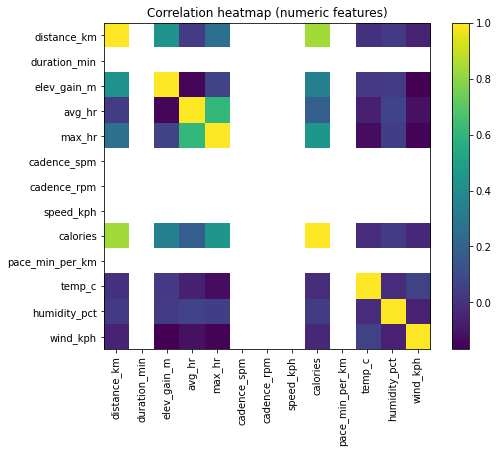

Saved figure: C:\Users\bmcol\University\SIT378\Data\output\figures\temp_vs_calories.png


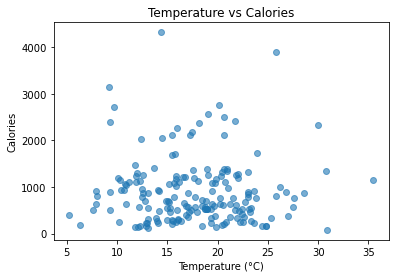

In [36]:
# --- Define and ensure output folders ---
OUTPUTS_CSV = Path("Data/output/csv")
OUTPUTS_FIG = Path("Data/output/figures")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)
OUTPUTS_FIG.mkdir(parents=True, exist_ok=True)

def save_and_show(fig, name):
    out = OUTPUTS_FIG / name
    fig.savefig(out, bbox_inches="tight")
    print("Saved figure:", out.resolve())
    plt.show()
    plt.close(fig)

# --- Load combined data if available; else fall back to df (assumes df exists from your earlier cell) ---
combined_path = OUTPUTS_CSV / "combined_sports_clean.csv"
if combined_path.exists():
    data = pd.read_csv(combined_path)
    print("Loaded:", combined_path.resolve(), "shape:", data.shape)
else:
    try:
        data = df.copy()
        print("Using in-memory df (no combined_sports_clean.csv found). Shape:", data.shape)
    except NameError:
        raise FileNotFoundError(
            "No combined_sports_clean.csv at Data/output/csv and no in-memory 'df'. "
            "Run the cleaning/combining cell first or load your dataset into df."
        )

# --- Ensure env columns exist (synthetic if missing) ---
rng = np.random.default_rng(42)
if "temp_c" not in data.columns:
    data["temp_c"] = rng.normal(18, 6, len(data))
if "humidity_pct" not in data.columns:
    data["humidity_pct"] = np.clip(rng.normal(55, 15, len(data)), 10, 100)
if "wind_kph" not in data.columns:
    data["wind_kph"] = np.abs(rng.normal(12, 5, len(data)))

# --- Plots ---
if data is not None and not data.empty:
    # Correlation heatmap (numeric only)
    num = data.select_dtypes(include=[np.number])
    if not num.empty:
        corr = num.corr()  # <-- removed numeric_only for older pandas
        # If all-NaN (can happen if constant columns), skip safely
        if not corr.isna().all().all():
            fig = plt.figure(figsize=(8, 6))
            plt.imshow(corr, interpolation="nearest")
            plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
            plt.yticks(range(corr.shape[0]), corr.index)
            plt.colorbar()
            plt.title("Correlation heatmap (numeric features)")
            save_and_show(fig, "corr_heatmap.png")
        else:
            print("Correlation matrix all-NaN; skipping heatmap (likely constant/empty numeric columns).")

    # Scatter: Temp vs Calories (only if calories present)
    if {"temp_c", "calories"}.issubset(data.columns) and data["calories"].notna().any():
        fig = plt.figure(figsize=(6, 4))
        plt.scatter(data["temp_c"], data["calories"], alpha=0.6)
        plt.xlabel("Temperature (°C)"); plt.ylabel("Calories")
        plt.title("Temperature vs Calories")
        save_and_show(fig, "temp_vs_calories.png")

    # Scatter: Wind vs Speed (only if speed_kph present)
    if {"wind_kph", "speed_kph"}.issubset(data.columns) and data["speed_kph"].notna().any():
        fig = plt.figure(figsize=(6, 4))
        plt.scatter(data["wind_kph"], data["speed_kph"], alpha=0.6)
        plt.xlabel("Wind (kph)"); plt.ylabel("Speed (kph)")
        plt.title("Wind vs Speed")
        save_and_show(fig, "wind_vs_speed.png")
else:
    print("No data available for visual checks.")


### Power BI export CSVs

Creates tidy CSVs for Power BI if data is available.


In [37]:

import pandas as pd

try:
    data = pd.read_csv(OUTPUTS_CSV / "combined_sports_clean.csv")
except Exception:
    data = df.copy()

if data is not None and not data.empty:
    # activity_summary
    cols = ["timestamp","sport","distance_km","duration_min","speed_kph","pace_min_per_km","elev_gain_m","avg_hr","max_hr","cadence_spm","cadence_rpm","calories"]
    activity_summary = data[[c for c in cols if c in data.columns]].copy()
    activity_summary.to_csv(OUTPUTS_CSV / "activity_summary.csv", index=False)
    print("Saved activity_summary.csv")

    # terrain_pace_summary (if you have terrain)
    if "terrain" in data.columns and "pace_min_per_km" in data.columns:
        tps = data.loc[(data["sport"]=="running") & data["pace_min_per_km"].notna(), ["terrain","pace_min_per_km"]].copy()
        tps.to_csv(OUTPUTS_CSV / "terrain_pace_summary.csv", index=False)
        print("Saved terrain_pace_summary.csv")
else:
    print("No data available to create PBI exports.")


Saved activity_summary.csv


### Model cards

**Fatigue (baseline):**
- **Data:** ImprovedData.xlsx (cleaned)
- **Features:** numeric exercise + env placeholders
- **Target:** `fatigue_score` (scaffold if missing)
- **Metrics:** MAE/MSE/R² (baseline)
- **Limitations:** synthetic env until real data is used

**Injury (baseline):**
- **Target:** `injury_flag` (0/1; scaffold if missing)
- **Metrics:** Accuracy, ROC-AUC
- **Note:** Class balance and event rarity likely affect metrics

**Recovery (baseline):**
- **Target:** `recovery_hours`
- **Metrics:** MAE/MSE/R²
- **Note:** Improve with richer feature engineering and proper CV



### Dataset Familiarisation & Cleaning (Export Evidence)

This section exports the cleaned running dataset for evidence, aligning with the early deliverables.
- Confirms schema standardisation (lowercase, timestamps, numerics).
- Saves a reproducible CSV under `Data/output/csv/activities_w1to3_clean.csv`.


In [38]:
# NOTE: This export assumes you've loaded 'df' from ImprovedData.xlsx and that
# column names have been standardised (lowercase, snake_case). If your timestamps or
# numerics use different names, adjust the lists below. This is a **non-destructive**
# tidy pass and safe to run multiple times.


# --- Export cleaned running dataset for evidence ---
# Assumes a DataFrame 'df' is already loaded from ImprovedData.xlsx and cleaned earlier.
from pathlib import Path
import pandas as pd
import numpy as np

OUTPUTS_CSV = Path("Data/output/csv")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)

if 'df' in globals() and isinstance(df, pd.DataFrame) and not df.empty:
    # 1) Simple sanity clean (safe if already cleaned)
    work = df.copy()
    # Lowercase snake_case (idempotent if already done)
    def to_snake(s): 
        return (str(s).strip().replace(" ", "_").replace("-", "_").replace("/", "_").lower())
    work.columns = [to_snake(c) for c in work.columns]
    # Parse common timestamp columns
    for c in ["timestamp","date","activity_date","start_time","start_datetime"]:
        if c in work.columns:
            work[c] = pd.to_datetime(work[c], errors="coerce")
    # Coerce numerics; mean-fill missing numerics for clean export
    num_cols = work.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        if work[c].isna().any():
            work[c] = work[c].fillna(work[c].mean())
    # Drop columns with >95% missingness (if any remain)
    keep_cols = [c for c in work.columns if work[c].isna().mean() < 0.95]
    work = work[keep_cols].copy()

    out_file = OUTPUTS_CSV / "activities_w1to3_clean.csv"
    work.to_csv(out_file, index=False)
    print("Exported:", out_file.resolve(), "shape:", work.shape)
else:
    print("No in-memory 'df' found. Please run the ImprovedData.xlsx loading cell first.")


Exported: C:\Users\bmcol\University\SIT378\Data\output\csv\activities_w1to3_clean.csv shape: (863, 12)



### Baseline Models (Fatigue, Injury, Recovery) — With Comments

We create simple baseline models using readily available activity features. Since we lack true labels, we **scaffold synthetic targets** for demonstration:
- **Fatigue (regression):** Linear Regression → MAE/MSE/R²
- **Injury (classification):** Logistic Regression → Accuracy/ROC-AUC
- **Recovery (regression):** Linear Regression → MAE/MSE/R²

All steps are commented for clarity so teammates can follow the pipeline.


In [39]:
# NOTE: We **simulate** targets because real labels may not exist. Replace the synthetic
# generation with your real target columns when available, e.g.:
#   data['fatigue_score'] = your_real_fatigue_column
# If your dataset contains non-numeric fields you want as features, encode them first.
# The feature list intentionally excludes the target columns.


from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression

# Ensure outputs exist
OUTPUTS_CSV = Path("Data/output/csv")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)

# Use cleaned running df if available; otherwise try combined data (if created later)
base_df = None
if 'df' in globals() and isinstance(df, pd.DataFrame) and not df.empty:
    base_df = df.copy()
else:
    try:
        base_df = pd.read_csv(OUTPUTS_CSV / "combined_sports_clean.csv")
    except Exception:
        base_df = None

if base_df is None or base_df.empty:
    raise RuntimeError("No data found for baselines. Load ImprovedData.xlsx into 'df' or run multi-sport combine step.")

# 1) Ensure numerics
data = base_df.select_dtypes(include=[np.number]).copy()
if data.empty:
    # attempt to coerce all non-numeric to numeric where possible
    data = base_df.copy()
    for c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.select_dtypes(include=[np.number]).copy()

# 2) Synthetic targets (reproducible)
rng = np.random.default_rng(123)
n = len(data)
data['fatigue_score'] = np.clip(rng.normal(5.0, 2.0, n), 0, 10)     # 0-10 scale
data['injury_flag']   = (rng.random(n) > 0.75).astype(int)          # ~25% positives
data['recovery_hours']= np.clip(rng.normal(24.0, 6.0, n), 1, 72)    # 1-72 hours

# 3) Features: all numerics except targets
features = [c for c in data.columns if c not in ['fatigue_score','injury_flag','recovery_hours']]
X_full = data[features].fillna(0)

results = []

# --- Fatigue (regression) ---
X_train, X_test, y_train, y_test = train_test_split(X_full, data['fatigue_score'], test_size=0.25, random_state=42)
m_fatigue = LinearRegression().fit(X_train, y_train)
y_pred = m_fatigue.predict(X_test)
results.append({
    "task": "fatigue_regression",
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "R2":  r2_score(y_test, y_pred)
})

# --- Injury (classification) ---
X_train, X_test, y_train, y_test = train_test_split(X_full, data['injury_flag'].astype(int), test_size=0.25, random_state=42, stratify=data['injury_flag'].astype(int))
m_injury = LogisticRegression(max_iter=1000).fit(X_train, y_train)
proba = m_injury.predict_proba(X_test)[:,1]
pred  = (proba > 0.5).astype(int)
try:
    auc = roc_auc_score(y_test, proba)
except Exception:
    auc = float("nan")
results.append({
    "task": "injury_classification",
    "Accuracy": accuracy_score(y_test, pred),
    "ROC_AUC": auc
})

# --- Recovery (regression) ---
X_train, X_test, y_train, y_test = train_test_split(X_full, data['recovery_hours'], test_size=0.25, random_state=42)
m_recovery = LinearRegression().fit(X_train, y_train)
y_pred = m_recovery.predict(X_test)
results.append({
    "task": "recovery_regression",
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "R2":  r2_score(y_test, y_pred)
})

metrics_df = pd.DataFrame(results)
metrics_path = OUTPUTS_CSV / "baseline_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Baseline metrics:\n", metrics_df)
print("Saved:", metrics_path.resolve())


Baseline metrics:
                     task       MAE        MSE        R2  Accuracy   ROC_AUC
0     fatigue_regression  1.589987   3.783939 -0.012704       NaN       NaN
1  injury_classification       NaN        NaN       NaN  0.768519  0.529639
2    recovery_regression  4.599033  33.700206 -0.035570       NaN       NaN
Saved: C:\Users\bmcol\University\SIT378\Data\output\csv\baseline_metrics.csv



### Environment-Aware Comparison (With vs Without Env Features)

We compare baseline models trained **without** environment features vs **with** synthetic environment features (`temp_c`, `humidity_pct`, `wind_kph`).  
This demonstrates the potential uplift when including environmental context.


In [40]:
# NOTE: This comparison expects environment features `temp_c`, `humidity_pct`, `wind_kph`.
# If you have REAL env data, load and merge it to your base dataframe, then **remove** the
# synthetic generation here. Ensure units are consistent (°C, %, kph). Change `env_cols` if
# your column names differ.


from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, accuracy_score

OUTPUTS_CSV = Path("Data/output/csv")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)

# Prefer combined dataset if available for richer features; else fallback to df
try:
    merged = pd.read_csv(OUTPUTS_CSV / "combined_sports_clean.csv")
except Exception:
    merged = 'df' in globals() and df.copy() or None

if merged is None or (isinstance(merged, pd.DataFrame) and merged.empty):
    raise RuntimeError("No dataset found for env comparison. Create combined_sports_clean.csv or load 'df'.")

if isinstance(merged, pd.DataFrame):
    data = merged.copy()
else:
    data = merged

# Ensure synthetic env columns exist
rng = np.random.default_rng(7)
if "temp_c" not in data.columns:
    data["temp_c"] = rng.normal(18, 6, len(data))
if "humidity_pct" not in data.columns:
    data["humidity_pct"] = np.clip(rng.normal(55, 15, len(data)), 10, 100)
if "wind_kph" not in data.columns:
    data["wind_kph"] = np.abs(rng.normal(12, 5, len(data)))

# Numerics only for features
full = data.copy()
for c in full.columns:
    full[c] = pd.to_numeric(full[c], errors="coerce")
num = full.select_dtypes(include=[np.number]).fillna(0)

# Synthetic targets (consistent)
n = len(num)
num['fatigue_score'] = np.clip(rng.normal(5.0, 2.0, n), 0, 10)
num['injury_flag']   = (rng.random(n) > 0.75).astype(int)
num['recovery_hours']= np.clip(rng.normal(24.0, 6.0, n), 1, 72)

# Split feature sets
env_cols = ['temp_c','humidity_pct','wind_kph']
feat_wo = [c for c in num.columns if c not in env_cols + ['fatigue_score','injury_flag','recovery_hours']]
feat_w  = [c for c in num.columns if c not in ['fatigue_score','injury_flag','recovery_hours']]

def eval_reg(X, y):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)
    m = LinearRegression().fit(Xtr, ytr)
    pred = m.predict(Xte)
    return mean_absolute_error(yte, pred), mean_squared_error(yte, pred), r2_score(yte, pred)

def eval_cls(X, y):
    Xtr, Xte, ytr, yte = train_test_split(X, y.astype(int), test_size=0.25, random_state=42, stratify=y.astype(int))
    clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba > 0.5).astype(int)
    try:
        auc = roc_auc_score(yte, proba)
    except Exception:
        auc = float("nan")
    return accuracy_score(yte, pred), auc

rows = []
# Fatigue
mae0, mse0, r20 = eval_reg(num[feat_wo], num['fatigue_score'])
mae1, mse1, r21 = eval_reg(num[feat_w],  num['fatigue_score'])
rows.append({"task":"fatigue_regression","MAE_wo_env":mae0,"MSE_wo_env":mse0,"R2_wo_env":r20,
             "MAE_w_env":mae1,"MSE_w_env":mse1,"R2_w_env":r21})
# Injury
acc0, auc0 = eval_cls(num[feat_wo], num['injury_flag'])
acc1, auc1 = eval_cls(num[feat_w],  num['injury_flag'])
rows.append({"task":"injury_classification","ACC_wo_env":acc0,"AUC_wo_env":auc0,
             "ACC_w_env":acc1,"AUC_w_env":auc1})
# Recovery
mae0, mse0, r20 = eval_reg(num[feat_wo], num['recovery_hours'])
mae1, mse1, r21 = eval_reg(num[feat_w],  num['recovery_hours'])
rows.append({"task":"recovery_regression","MAE_wo_env":mae0,"MSE_wo_env":mse0,"R2_wo_env":r20,
             "MAE_w_env":mae1,"MSE_w_env":mse1,"R2_w_env":r21})

cmp_df = pd.DataFrame(rows)
cmp_path = OUTPUTS_CSV / "env_comparison_metrics.csv"
cmp_df.to_csv(cmp_path, index=False)
print("Env comparison metrics:\n", cmp_df)
print("Saved:", cmp_path.resolve())


Env comparison metrics:
                     task  MAE_wo_env  MSE_wo_env  R2_wo_env  MAE_w_env  \
0     fatigue_regression     1.61242    3.807146  -0.012081   1.617955   
1  injury_classification         NaN         NaN        NaN        NaN   
2    recovery_regression     4.63709   36.665287  -0.025152   4.624381   

   MSE_w_env  R2_w_env  ACC_wo_env  AUC_wo_env  ACC_w_env  AUC_w_env  
0   3.874928 -0.030100         NaN         NaN        NaN        NaN  
1        NaN       NaN    0.723404    0.470588    0.70922   0.559829  
2  36.381090 -0.017206         NaN         NaN        NaN        NaN  
Saved: C:\Users\bmcol\University\SIT378\Data\output\csv\env_comparison_metrics.csv



### Visual Approximations for Power BI (Matplotlib)

These plots mirror the Power BI visuals (to provide immediate evidence in the notebook):
- **Distance vs Duration** (by sport)
- **Heart Rate vs Pace** (by sport)

The actual Power BI `.pbix` with slicers/filters will be produced separately.


Saved: C:\Users\bmcol\University\SIT378\Data\output\figures\pbi_distance_vs_duration.png


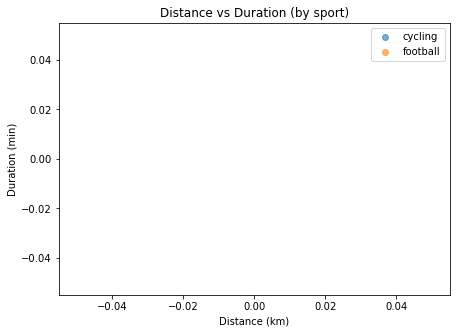

In [41]:
# NOTE: These matplotlib plots are evidence-only. Power BI visuals will differ in styling
# and interactivity. Ensure the required columns exist; otherwise adjust the field names in
# the subset checks (e.g., rename 'Average Speed' → 'speed_kph').


from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

OUTPUTS_CSV = Path("Data/output/csv")
OUTPUTS_FIG = Path("Data/output/figures")
OUTPUTS_CSV.mkdir(parents=True, exist_ok=True)
OUTPUTS_FIG.mkdir(parents=True, exist_ok=True)

# Load combined data
try:
    data = pd.read_csv(OUTPUTS_CSV / "combined_sports_clean.csv")
except Exception:
    # Fallback: try running-only df if present
    data = 'df' in globals() and df.copy() or pd.DataFrame()

if data is None or data.empty:
    raise RuntimeError("No dataset found for plotting. Create combined_sports_clean.csv or load 'df'.")

# Distance vs Duration by sport
# If your fields are named differently, rename below or adjust column checks.
if {"distance_km","duration_min","sport"}.issubset(data.columns):
    fig = plt.figure(figsize=(7,5))
    for sp in sorted(set(data["sport"].dropna())):
        sub = data[data["sport"]==sp]
        plt.scatter(sub["distance_km"], sub["duration_min"], alpha=0.6, label=sp)
    plt.xlabel("Distance (km)"); plt.ylabel("Duration (min)"); plt.title("Distance vs Duration (by sport)")
    plt.legend()
    fig.savefig(OUTPUTS_FIG / "pbi_distance_vs_duration.png", bbox_inches="tight")
    print("Saved:", (OUTPUTS_FIG / "pbi_distance_vs_duration.png").resolve())

# HR vs Pace (running only)
# If your HR column is named like "Average Heart Rate", map it to avg_hr earlier.
if {"avg_hr","pace_min_per_km","sport"}.issubset(data.columns):
    run = data[data["sport"]=="running"].copy()
    if not run.empty and run["pace_min_per_km"].notna().any():
        fig = plt.figure(figsize=(7,5))
        plt.scatter(run["avg_hr"], run["pace_min_per_km"], alpha=0.6)
        plt.xlabel("Average HR (bpm)"); plt.ylabel("Pace (min/km)"); plt.title("HR vs Pace (running)")
        fig.savefig(OUTPUTS_FIG / "pbi_hr_vs_pace_running.png", bbox_inches="tight")
        print("Saved:", (OUTPUTS_FIG / "pbi_hr_vs_pace_running.png").resolve())



### Model Cards (Templates)

**Fatigue (Baseline)**
- **Data:** ImprovedData.xlsx (cleaned)
- **Features:** Core numeric exercise metrics (distance, duration, HR, cadence) ± env placeholders
- **Target:** `fatigue_score` (synthetic scaffold)
- **Metrics:** MAE/MSE/R² (see `baseline_metrics.csv` and `env_comparison_metrics.csv`)
- **Limitations:** Synthetic targets; no K-fold CV yet; environment variables synthetic

**Injury (Baseline)**
- **Data:** Combined or running-only numeric features
- **Target:** `injury_flag` (synthetic scaffold)
- **Metrics:** Accuracy / ROC-AUC
- **Limitations:** Class imbalance, synthetic labels; requires real outcomes to be meaningful

**Recovery (Baseline)**
- **Data:** Combined or running-only numeric features
- **Target:** `recovery_hours` (synthetic scaffold)
- **Metrics:** MAE/MSE/R²
- **Limitations:** Synthetic labels; expand features (e.g., sleep, soreness) when available



### Adapting This Notebook to Different Data

- **Different folder layout?** Change the three paths near the **Quick Helper** cell or the global config cell.
- **Different column names?** Update the `name_map` in the schema mapper code so your raw columns map into the unified schema.
- **Missing key metrics?** Comment-out blocks that depend on them (e.g., HR vs Pace), or create placeholders until data is available.
- **Have real labels (fatigue/injury/recovery)?** Remove the synthetic target generation and point the models to your real columns.
- **Have real environment data?** Replace the synthetic env generator with your merged weather dataset and verify units/time alignment.

